## Langevin dynamics experiment
A small module to run a naive implementation of Langevin dynamics. Currently $N=100$ is pretty small, but the size of the tensor is the main constraint. 
An **important note** is that the Mannelli paper doesn't actually explicitly run Langevin dynamics. They instead run the Langevin State Evolution (LSE) equations, which are an analytic solution for average correlations (either autocorrelations or correlation with the signal) of the Langevin state as a function of time. It would be nice to verify that their results are robust against theory, but it may prove computationally intractable for the large $N$ needed for their results to hold. 

In [1]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
import time
import torch

In [19]:

def generate_spiked_matrix_tensor(
        x_star: np.ndarray | torch.Tensor,
        Delta2: float,
        Delta_p: float,
        p: int = 3,
        dtype=torch.float32,
        device: str | None = None,
        seed: int | None = None,
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    if isinstance(x_star, np.ndarray):
        x_star = torch.tensor(x_star, dtype=dtype, device=device)
    else:
        x_star = x_star.to(dtype=dtype, device=device)

    N = x_star.shape[0]
    assert p >= 2, "tensor order p must be ≥2"

    Y_signal = torch.outer(x_star, x_star) / np.sqrt(N)
    noise_ut = torch.randn(N, N, dtype=dtype, device=device) * np.sqrt(Delta2)
    noise_ut = torch.triu(noise_ut, diagonal=1)
    Y = Y_signal + noise_ut + noise_ut.T
    Y.fill_diagonal_(0.)

    if p == 2:
        return Y

    if p != 3:
        raise NotImplementedError("Efficient symmetrisation is provided for p=3 only")

    coeff = np.sqrt(math.factorial(p - 1)) / (N ** ((p - 1) / 2))
    T_signal = coeff * torch.einsum('i,j,k->ijk', x_star, x_star, x_star)

    raw = torch.randn(N, N, N, dtype=dtype, device=device) * np.sqrt(Delta_p)
    perms = [(0, 1, 2), (1, 0, 2), (2, 1, 0), (0, 2, 1), (1, 2, 0), (2, 0, 1)]
    T_noise = sum(raw.permute(p) for p in perms) / np.sqrt(6)

    T = T_signal + T_noise
    return Y, T


def langevin_dynamics_projected_gpu(x0, Y, T, delta2, deltap, steps=1000, step_size=0.01, device='cuda', seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    N = x0.shape[0]
    x = x0.clone().to(device)
    x = x / torch.norm(x) * torch.sqrt(torch.tensor(N, dtype=torch.float32, device=device))
    traj = [x.clone()]

    # Precompute tensor prefactor for p=3
    tensor_coeff = math.sqrt(2.0) / (deltap * N)

    for _ in tqdm(range(steps), desc="Langevin algorithm progress", unit='step'):
        grad_matrix = -1.0 / delta2 * (Y @ x) / torch.sqrt(torch.tensor(N, dtype=torch.float32, device=device))

        # Correct tensor gradient (no overcounting, correct prefactor)
        w = torch.einsum("ijk,j,k->i", T, x, x)
        grad_tensor = -tensor_coeff * w

        grad = grad_matrix + grad_tensor
        noise = torch.randn_like(x)
        x = x - step_size * grad + torch.sqrt(torch.tensor(2.0 * step_size, device=device)) * noise
        x = x / torch.norm(x) * torch.sqrt(torch.tensor(N, dtype=torch.float32, device=device))
        traj.append(x.clone())

    return torch.stack(traj)


In [45]:
N       = 100
p       = 3
Delta2  = 0.5
Delta_p = 1

# Draw a random vector on S_{N−1} of radius sqrt(N)
x_star = np.random.randn(N).astype(np.float32)
x_star /= np.linalg.norm(x_star) 
x_star *= np.sqrt(N)

Y, T = generate_spiked_matrix_tensor(x_star, Delta2, Delta_p, p=p, seed=42)

print(Y.shape)
print(T.shape) 


torch.Size([100, 100])
torch.Size([100, 100, 100])


In [46]:
x_0 = np.random.randn(N)
x_0 /= np.linalg.norm(x_0) 
x_0 *= np.sqrt(N)
x_0 = torch.tensor(x_0, dtype=torch.float32)

traj = langevin_dynamics_projected_gpu(x_0, Y, T, delta2=Delta2, deltap=Delta_p, steps=10000, step_size=0.01, seed=10)

Langevin algorithm progress: 100%|██████████| 10000/10000 [00:03<00:00, 2610.92step/s]


In [5]:
def run_langevin_cpu_exact(x_0, Y, T, Delta2, Delta_p,
                           p=3, dt=1e-2, max_steps=15000, seed=None):
    """
    CPU Langevin that exactly matches your NumPy version:

      grad_H_matrix  =  (1/(Δ2 * sqrt(N))) * (Y @ x)
      w              =  einsum('ijk,j,k->i', T, x, x)
      grad_H_tensor  =  (sqrt((p-1)!)/(Δp * N^((p-1)/2))) * w
      x_temp         =  x + dt*grad_H + noise
      x              =  √N * x_temp / ||x_temp||

    Returns the full trajectory (max_steps+1, N).
    """
    if seed is not None:
        torch.manual_seed(seed)

    device = 'cuda'
    N = x_0.shape[0]

    # initial x
    x = x_0

    # ensure everything is float32 on CPU
    Y = Y.to(device=device, dtype=torch.float32)
    T = T.to(device=device, dtype=torch.float32)
    x = x.to(device=device, dtype=torch.float32)

    traj = [x.clone()]

    # precompute constant for tensor part
    tensor_coeff = math.sqrt(math.factorial(p-1)) / (Delta_p * (N**((p-1)/2)))

    for _ in tqdm(range(max_steps)):
        grad_H_matrix = (1.0 / (Delta2 * math.sqrt(N))) * (Y @ x)

        # w_i = sum_{jk} T_{i,j,k} x_j x_k
        w = torch.einsum('ijk,j,k->i', T, x, x)
        grad_H_tensor = tensor_coeff * w

        grad_H = grad_H_matrix + grad_H_tensor

        # Euler step + noise
        noise = torch.randn(N, dtype=torch.float32, device=device) * math.sqrt(2 * dt)
        x_temp = x + dt * grad_H + noise

        # Project back to sphere
        x = x_temp * (math.sqrt(N) / torch.norm(x_temp))

        traj.append(x.clone())

    return torch.stack(traj)  # shape (max_steps+1, N)


In [47]:
traj_cpu = run_langevin_cpu_exact(x_0, Y, T, Delta2, Delta_p, max_steps=10000, seed=10)

100%|██████████| 10000/10000 [00:02<00:00, 3938.68it/s]


torch.Size([10001, 100])


/tmp/ipykernel_1594/2390187512.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  corr = 1/N * (traj.cpu() @ x_star)
/tmp/ipykernel_1594/2390187512.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  corr_cpu = 1/N * (traj_cpu.cpu() @ x_star)


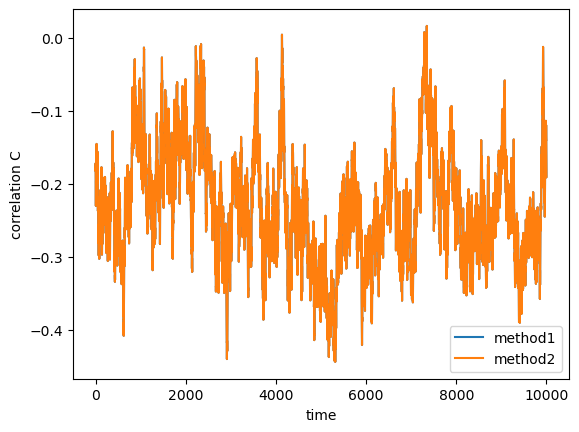

In [48]:
corr = 1/N * (traj.cpu() @ x_star)
corr_cpu = 1/N * (traj_cpu.cpu() @ x_star)

plt.plot(corr, label='method1')
plt.plot(corr_cpu, label='method2')

plt.legend()
plt.ylabel("correlation C")
plt.xlabel("time")
print(traj.shape)

In [33]:
from tqdm import tqdm

def langevin_dynamics_projected(x0, Y, T, delta2, deltap, p, steps, step_size, seed=None):
    """
    Run Langevin dynamics on the sphere using projection to enforce the constraint.

    Args:
        x0 (np.ndarray): Initial vector of shape (N,), assumed to have norm sqrt(N).
        Y (np.ndarray): Spiked matrix of shape (N, N).
        T (np.ndarray): Spiked tensor of shape (N,)*p.
        delta2 (float): Noise variance for the matrix.
        deltap (float): Noise variance for the tensor.
        p (int): Tensor order.
        steps (int): Number of Langevin steps.
        step_size (float): Step size (epsilon).
        seed (int, optional): Random seed.

    Returns:
        traj (np.ndarray): Array of shape (steps+1, N) with Langevin trajectory.
    """
    if seed is not None:
        np.random.seed(seed)

    N = x0.shape[0]
    x = x0.copy()
    traj = [x.copy()]

    for _ in tqdm(range(steps), desc="Langevin progress"):
        # Gradient of matrix term: -1/Delta2 * Y @ x / sqrt(N)
        grad_matrix = -1 / delta2 * (Y @ x) / np.sqrt(N)

        # Gradient of tensor term: -1/Delta_p * contraction
        grad_tensor = np.zeros_like(x)
        for i in range(N):
            slices = [slice(None)] * p
            for idx in range(p):
                slices[idx] = i
                grad_tensor[i] -= np.sum(T[tuple(slices)] * np.prod([x[j] for j in range(N) if j != i]))
                slices[idx] = slice(None)  # reset
        grad_tensor *= np.sqrt(math.factorial(p - 1)) / (deltap * N**((p - 1)/2))

        grad = grad_matrix + grad_tensor

        # Langevin update with noise
        noise = np.random.normal(0, 1, size=N)
        x = x - step_size * grad + np.sqrt(2 * step_size) * noise

        # Project back to the sphere
        x = np.sqrt(N) * x / np.linalg.norm(x)

        traj.append(x.copy())

    return np.array(traj)


### Do one trial

In [50]:
# trial
N = 100 # dimensionality
p = 3 # rank of tensor
deltap = 1.8
delta2 = 0.7

x_star, Y, T = generate_spiked_data(N, p, delta2=delta2, deltap=deltap, seed=42)

x_0 = np.random.randn(N)
x_0 /= np.linalg.norm(x_0) 
x_0 *= np.sqrt(N)

traj = langevin_dynamics_projected(x_0, Y, T, delta2=delta2, deltap=deltap, p=p, steps=1000, step_size=0.01, seed=42)

Langevin progress: 100%|██████████| 1000/1000 [00:10<00:00, 92.75it/s]


/tmp/ipykernel_148296/2080937208.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  corr = 1/N * (traj.cpu() @ x_star)


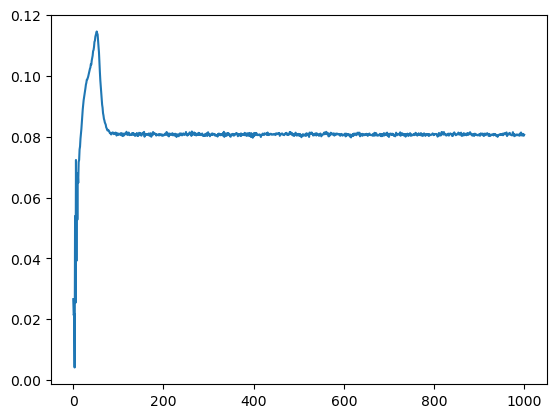

In [50]:
corr = 1/N * (traj.cpu() @ x_star)
plt.plot(corr)

In [ ]:
# Parameters
N = 100
p = 3
delta2 = 0.7
deltap_list = [1.8, 1.4, 1.1, 0.64]
n_seeds = 10
steps = 1000
step_size = 0.01

avg_corrs = {}

for deltap in deltap_list:
    all_corrs = []
    print(f"Running for Δp = {deltap}")
    for seed in range(n_seeds):
        x_star, Y, T = generate_spiked_data(N, p, delta2=delta2, deltap=deltap, seed=seed)

        x_0 = np.random.randn(N)
        x_0 /= np.linalg.norm(x_0)
        x_0 *= np.sqrt(N)

        traj = langevin_dynamics_projected(x_0, Y, T, delta2=delta2, deltap=deltap, p=p,
                                           steps=steps, step_size=step_size, seed=seed)

        corr = (traj @ x_star) / N
        all_corrs.append(corr)

    avg_corr = np.mean(all_corrs, axis=0)
    avg_corrs[deltap] = avg_corr



Running for Δp = 1.8


Langevin algorithm progress: 100%|██████████| 1000/1000 [00:03<00:00, 317.64step/s]


Running for Δp = 1.4


Langevin algorithm progress: 100%|██████████| 1000/1000 [00:03<00:00, 317.06step/s]


Running for Δp = 1.1


Langevin algorithm progress: 100%|██████████| 1000/1000 [00:03<00:00, 299.42step/s]


Running for Δp = 0.64


Langevin algorithm progress: 100%|██████████| 1000/1000 [00:03<00:00, 266.52step/s]


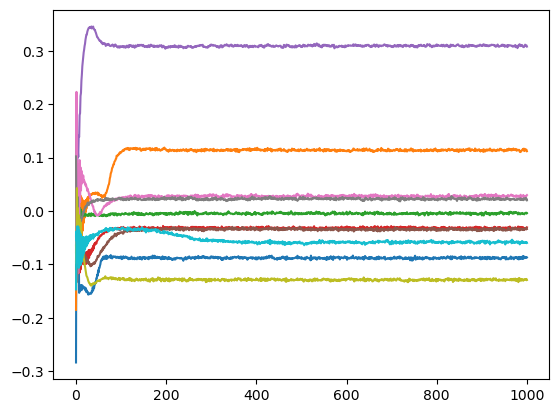

In [58]:
for i in range(len(all_corrs)):
    plt.plot(all_corrs[i], label=f"Seed {i+1}")

Different seeded realizations have vastly different $\bar{C}(t)$ curves. Sensitivity to step size? Thermal noise $\eta$? 

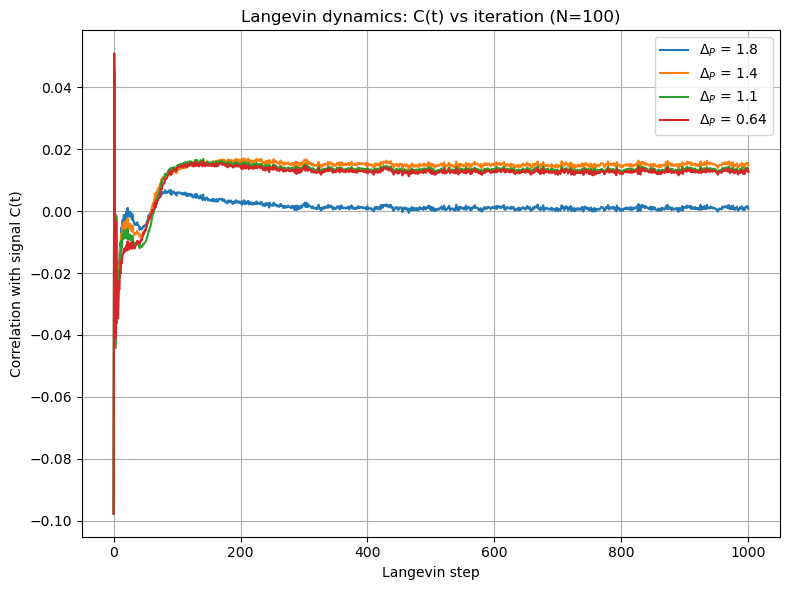

In [56]:
plt.figure(figsize=(8, 6))
for deltap, corr in avg_corrs.items():
    plt.plot(corr, label=fr'$\Delta_P$ = {deltap}')
plt.xlabel("Langevin step")
plt.ylabel("Correlation with signal C(t)")
plt.title("Langevin dynamics: C(t) vs iteration (N=100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
